У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from darts import TimeSeries
from darts import concatenate
from darts.utils.statistics import plot_acf, check_seasonality
from darts.utils.statistics import plot_residuals_analysis
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
from darts.models import XGBModel
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import plot_hist

In [2]:
# Зчитуємо дані train.csv.zip в pandas dataframe

raw_df = pd.read_csv('demand-forecasting-kernels-only/train.csv.zip')

In [3]:
# Перевіряємо загальний вигляд даних

raw_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
# Перевіряємо типи даних стовпців

raw_df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [5]:
# Змінюємо тип даних стовпця date на datetime

raw_df['date'] = pd.to_datetime(raw_df['date'])

In [6]:
# Встановлюємо стовпець date як індекс для датафрейму

raw_df.set_index('date', inplace=True)

In [7]:
# Виводимо перші 10 рядків отриманого датафрейму та інформацію про датафрейм

display(raw_df.head(10))
raw_df.info()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



**Загальна динаміка продажів товарів 1 і 2 по всіх магазинах**

In [8]:
'''Відбираємо лише дані для товару 1 і далі для кожної дати знаходимо середню к-сть його продажів по всіх магазинах,
мінімальний і максимальний продаж (щоб використати їх далі як діапазон довірчого інтервалу на візуалізації)
'''

raw_df_item_1 = raw_df[raw_df['item'] == 1]
groups_1 = raw_df_item_1.groupby([raw_df_item_1.index]).agg({"sales": ["mean", "max", "min"]})
groups_1

sales        
            mean max min
date                    
2013-01-01  13.3  20   7
2013-01-02   9.9  16   4
2013-01-03  12.7  20   8
2013-01-04  14.5  22   7
2013-01-05  14.9  22   8
...          ...  ..  ..
2017-12-27  15.4  19  13
2017-12-28  17.8  26   8
2017-12-29  20.7  34  15
2017-12-30  23.6  31  10
2017-12-31  22.7  31  16

[1826 rows x 3 columns]

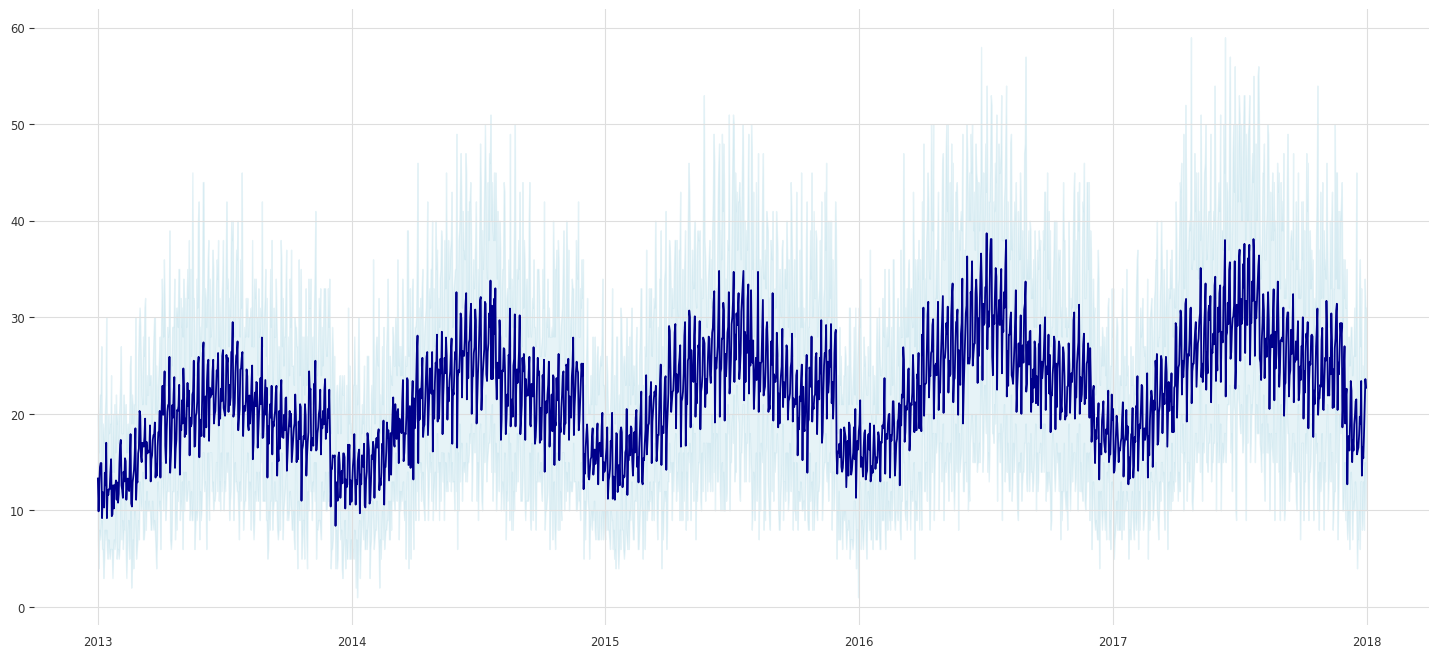

In [9]:
# Будуєио графік динаміки середніх продажів товару 1 і довірчий інтервал (який включає весь діапазон значень з різних магазинів)

plt.figure(figsize = (18, 8))
plt.plot(groups_1.index, groups_1['sales']['mean'], color = 'darkblue')
plt.fill_between(groups_1.index, groups_1['sales']['min'], groups_1['sales']['max'], color = 'lightblue', alpha = .3)
plt.show()

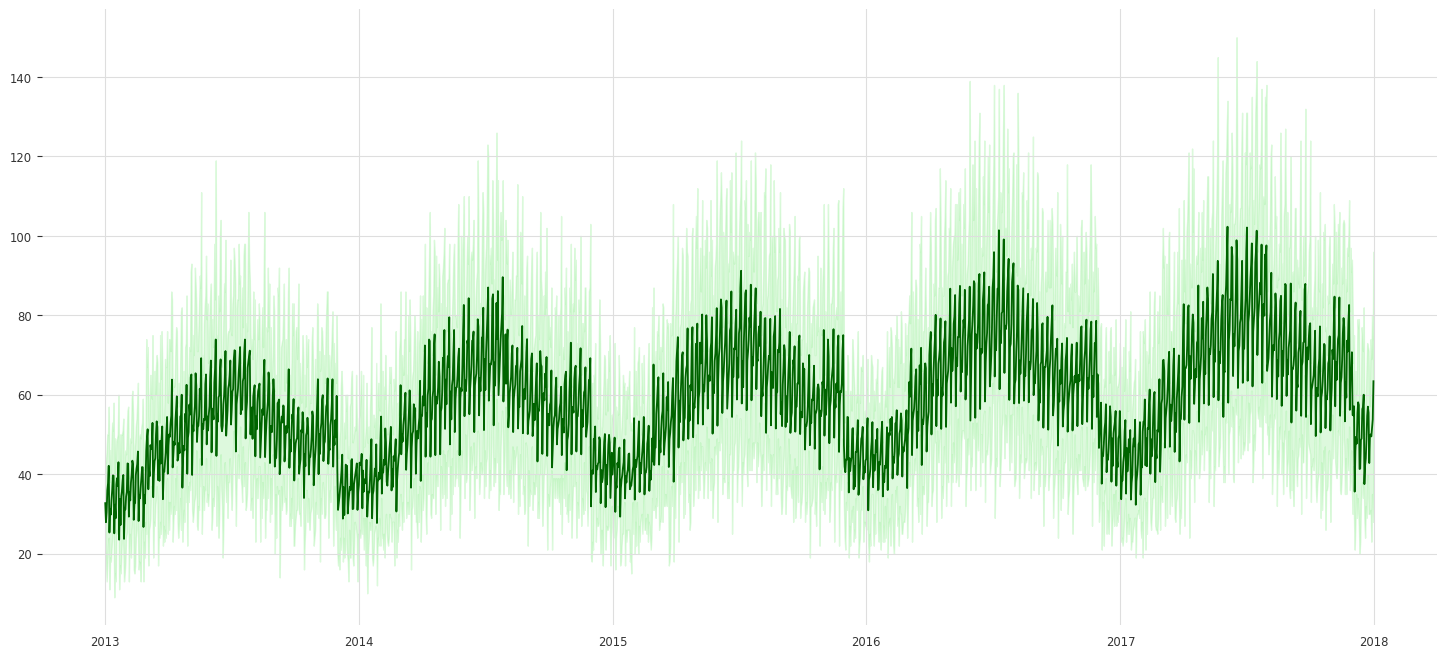

In [10]:
# Аналогічно будуєио графік динаміки середніх продажів товару 2 і відповідний довірчий інтервал

raw_df_item_2 = raw_df[raw_df['item'] == 2]
groups_2 = raw_df_item_2.groupby([raw_df_item_2.index]).agg({"sales": ["mean", "max", "min"]})
plt.figure(figsize = (18, 8))
plt.plot(groups_2.index, groups_2['sales']['mean'], color = 'darkgreen')
plt.fill_between(groups_2.index, groups_2['sales']['min'], groups_2['sales']['max'], color = 'lightgreen', alpha = .3)
plt.show()

**Висновок**:\
В динаміці середніх продажів і товару 1, і товару 2 по всіх магазинах помітний тренд збільшення і чітко виражена сезонність (продажі наростають до середини кожного року і далі йдуть на спад). Тобто динаміка цих товарів схожа.\
Єдина помітна відмінність між середніми продажами товарів 1 і 2 у їх масштабах. Товар 2 продається в середньому щонайменше удвічі краще.  

**Місячна динаміка продажів товарів 1 і 2 по всіх магазинах**

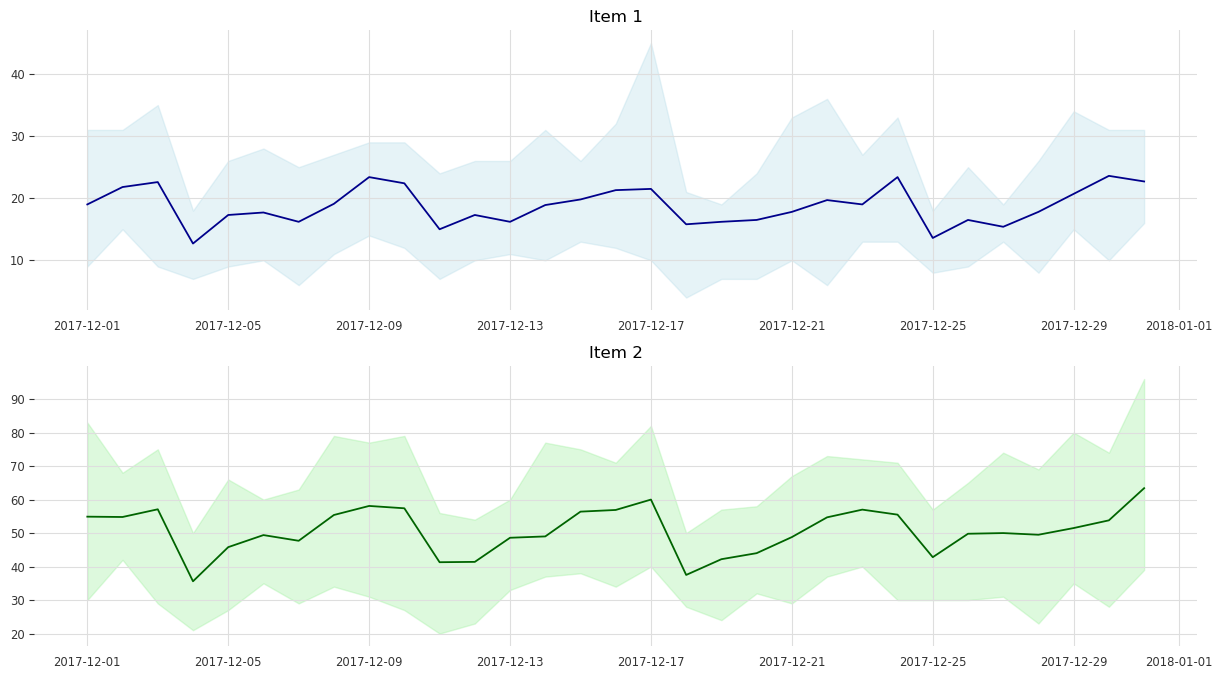

In [11]:
raw_df_item_1 = raw_df[(raw_df['item'] == 1) & (raw_df.index >= '2017-12-01')]
groups_1 = raw_df_item_1.groupby([raw_df_item_1.index]).agg({"sales": ["mean", "max", "min"]})

raw_df_item_2 = raw_df[(raw_df['item'] == 2) & (raw_df.index >= '2017-12-01')]
groups_2 = raw_df_item_2.groupby([raw_df_item_2.index]).agg({"sales": ["mean", "max", "min"]})

plt.figure(figsize = (15, 8))

plt.subplot(2, 1, 1)
plt.plot(groups_1.index, groups_1['sales']['mean'], color = 'darkblue')
plt.fill_between(groups_1.index, groups_1['sales']['min'], groups_1['sales']['max'], color = 'lightblue', alpha = .3)
plt.title('Item 1')

plt.subplot(2, 1, 2)
plt.plot(groups_2.index, groups_2['sales']['mean'], color = 'darkgreen')
plt.fill_between(groups_2.index, groups_2['sales']['min'], groups_2['sales']['max'], color = 'lightgreen', alpha = .3)
plt.title('Item 2')

plt.show()

**Висновок**:\
В місячній динаміці середніх продажів (останній місяць спостережень) і товару 1, і товару 2 помітна сезонність (продажі ростуть ближче до вихідних днів з піками у вихідні, і падають на початок кожного тижня). Для товару 2 така динаміка є більш вираженою. 

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

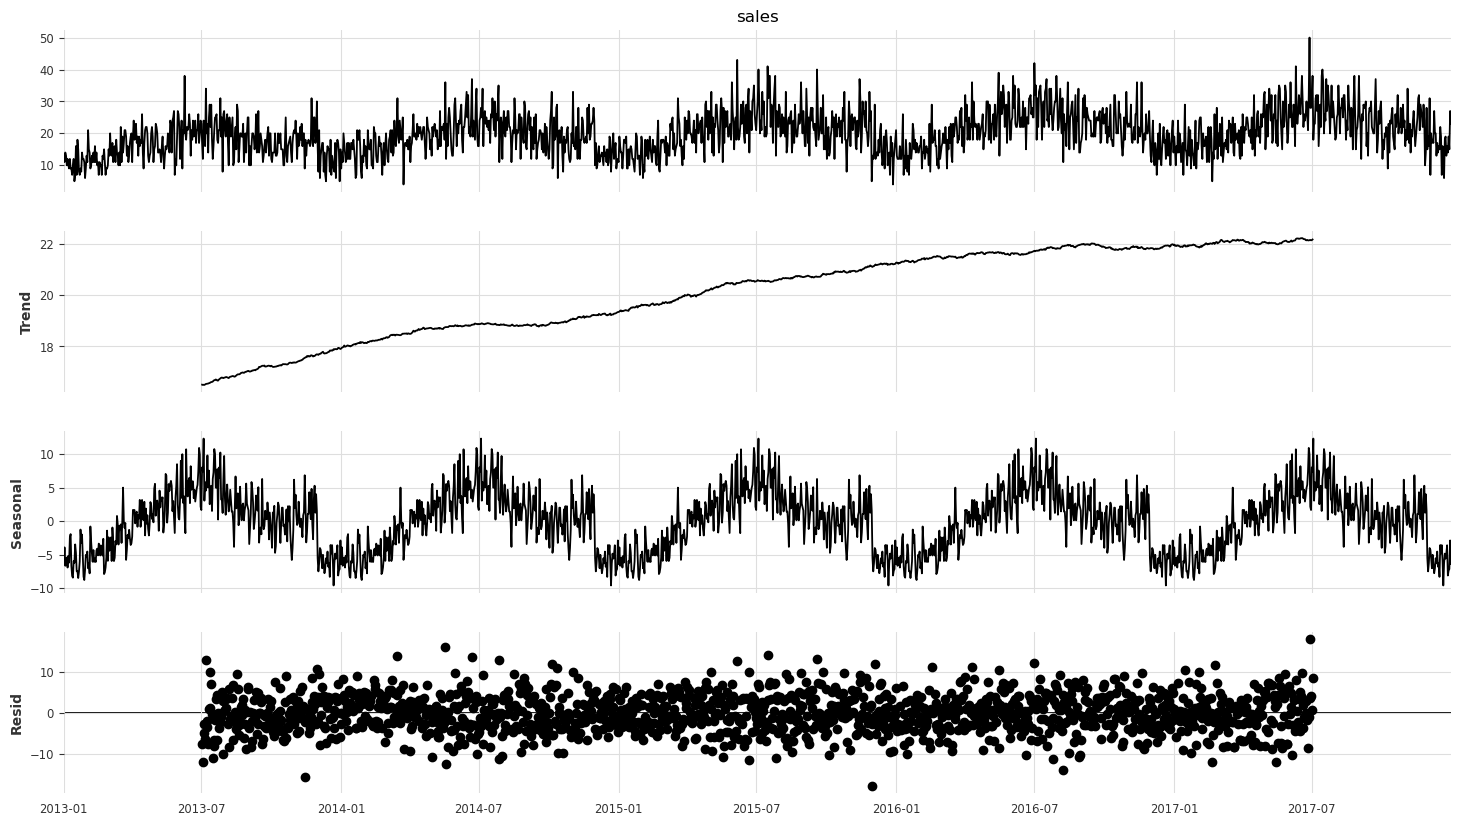

In [12]:
# Виділення підмножини даних, що відповідає продажам товару 1 у магазині 1

raw_df_item_1_store_1 = raw_df[(raw_df['item'] == 1) & (raw_df['store'] == 1)]

# Візуалізація адитивної декомпозиції для часового ряду
decomp_viz = seasonal_decompose(raw_df_item_1_store_1['sales'],
                                              model='additive',
                                              period = 365)
fig = decomp_viz.plot()
fig.set_size_inches((16, 9))
plt.show()

**Висновок**:\
З візуалізації адитивної декомпозиції чітко видно зростаючий тренд, яскраво виражену сезонність в межах кожного року (збільшення продажів до середини року і зменшення до кінця), залишки зосереджені навколо нуля і не мають паттерну.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [13]:
# Завантаження даних в darts

series = TimeSeries.from_dataframe(raw_df_item_1_store_1, value_cols='sales')
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

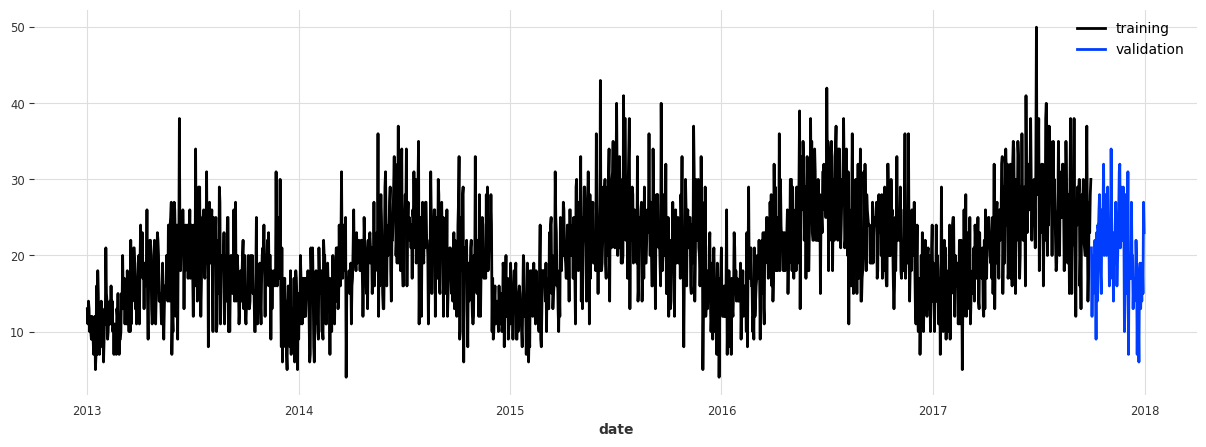

In [14]:
# Розбиття даних на тренувальні і валідаційні
train, val = series.split_before(pd.Timestamp("2017-10-01"))

# Візуалізація тренувальної і валідаційної частин даних
plt.figure(figsize = (15, 5))
train.plot(label="training")
val.plot(label="validation")
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

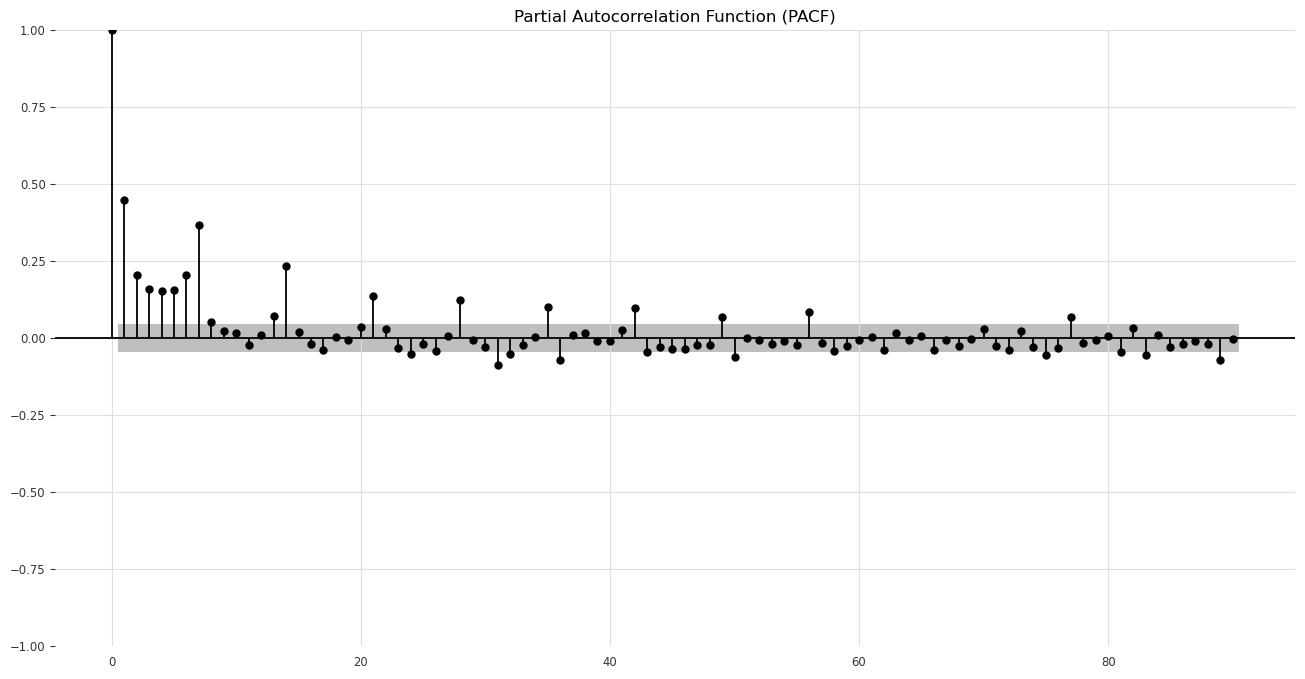

In [15]:
# Візуалізація часткової автокореляційної функції (PACF)

plt.rc('figure', figsize = (16,8))
plot_pacf(series.values(), lags = 90, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Висновок**:\
Статистично значущими є лаги до 1-7, 14, 21, 28, 35, 42, ... \
Тобто найближчі 7 лагів і далі кожен наступний з перідом 7 є важливими для прогнозування.\
Важливість лагів, які не є кратними 7, але демонструють статистичну значимість, наприклад, лаг 31, треба аналізувати додатково.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [16]:
is_seasonal, period = check_seasonality(train, alpha = 0.05)
if is_seasonal:
    print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.


**Висновок:**\
В тренувальному ряді даних має місце сезонність з періодом 7.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

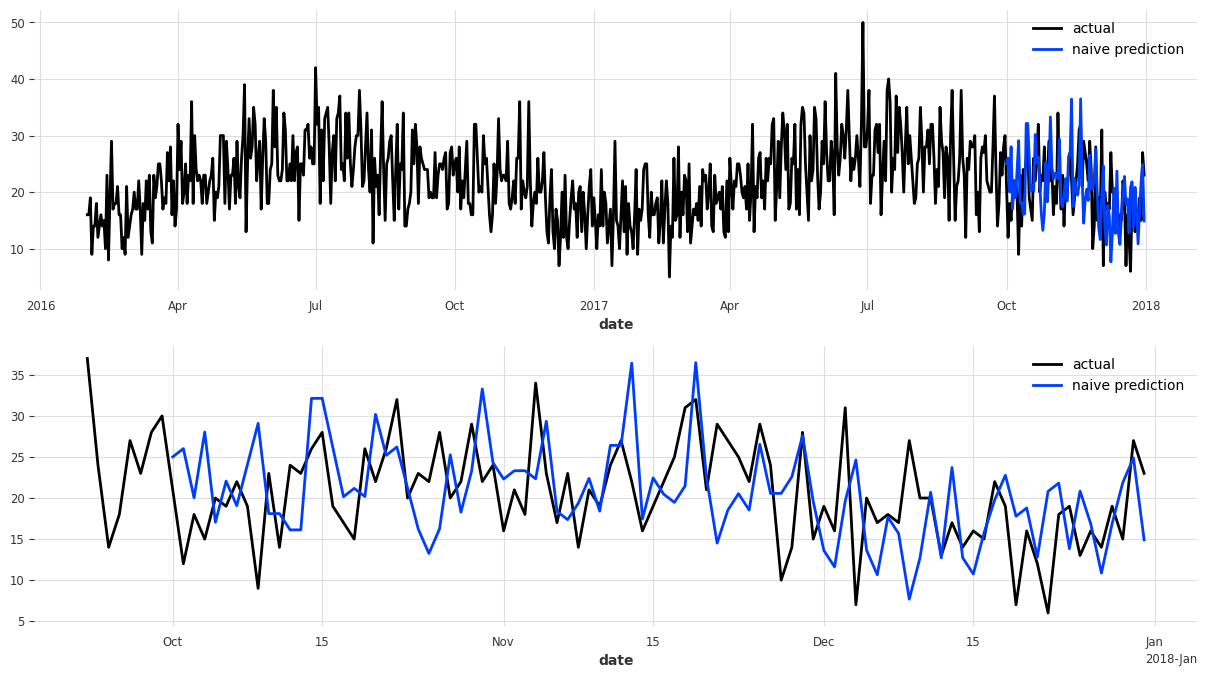

In [17]:
# Модель NaiveSeasonal з сезонністю 365

seasonal_model = NaiveSeasonal(K = 365)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

# Модель NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

# Комбінована модель

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

# Візуалізація передбачення проти справжніх даних

plt.figure(figsize = (15, 8))
plt.subplot(2, 1, 1)
series[-700:].plot(label = "actual")
combined_forecast.plot(label = "naive prediction")

plt.subplot(2, 1, 2)
series[-100:].plot(label = "actual")
combined_forecast.plot(label = "naive prediction")

plt.show()

**Висновок:**\
Загальні тенденції модель вгадала. Але величина і напрям коливань в актуальних і передбачених даних при детальному розгляді все ж мають помітні відмінності.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [18]:
print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(val, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 34.26%.


**Висновок:**\
Помилка прогнозу у 34,26% є досить великою. Модель не є якісною.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 24.84%


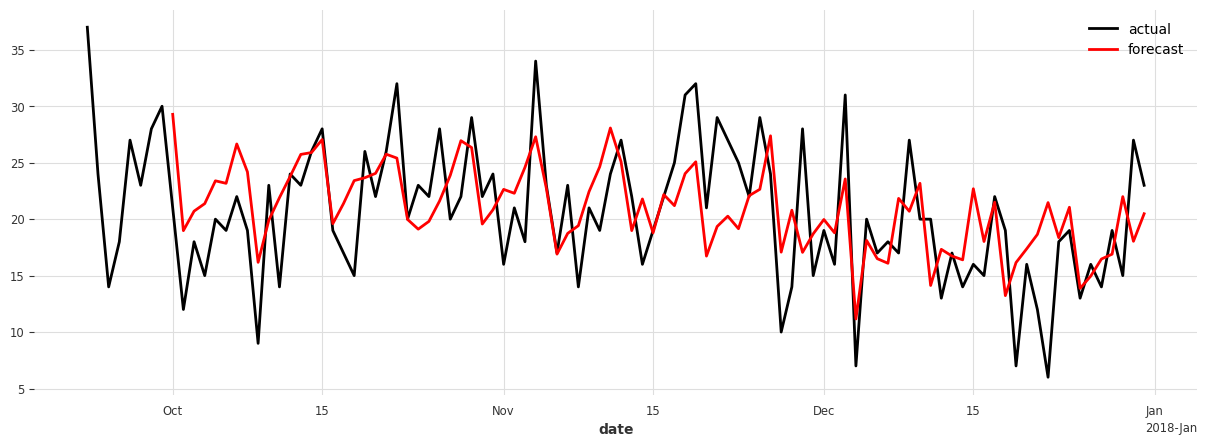

In [19]:
def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def enrich_with_date_features(df):
  # Feature Extraction
  df["dayofweek"] = df['date'].dt.dayofweek
  df["week"] = df['date'].dt.isocalendar().week
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model_xgb = XGBModel(
    lags = 365,  # Використання останніх 365 спостережень для прогнозування
    output_chunk_length = 1,  # Прогнозування на 1 крок вперед
    n_estimators = 200,  # Кількість дерев у моделі
    max_depth = 6,  # Максимальна глибина кожного дерева
    learning_rate = 0.1,  # Коефіцієнт навчання
    subsample = 0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree = 0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model_xgb.fit(train_transformed)
pred = model_xgb.predict(len(val))
forecast_xgb = scaler.inverse_transform(pred)

eval_forecast(model_xgb, val, forecast_xgb)

plt.figure(figsize = (15, 5))
series[-100:].plot(label = 'actual')
forecast_xgb.plot(label = 'forecast', color='red')
plt.legend()
plt.show()

**Висновок**:\
Помилка прогнозу, метрика MAPE, показує кращий результат від попереднього (24,84% проти 34,26%), але все ж залишається високою.\
Судячи з візуалізації, модель не достатньо схоплює потрібну величину коливань.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

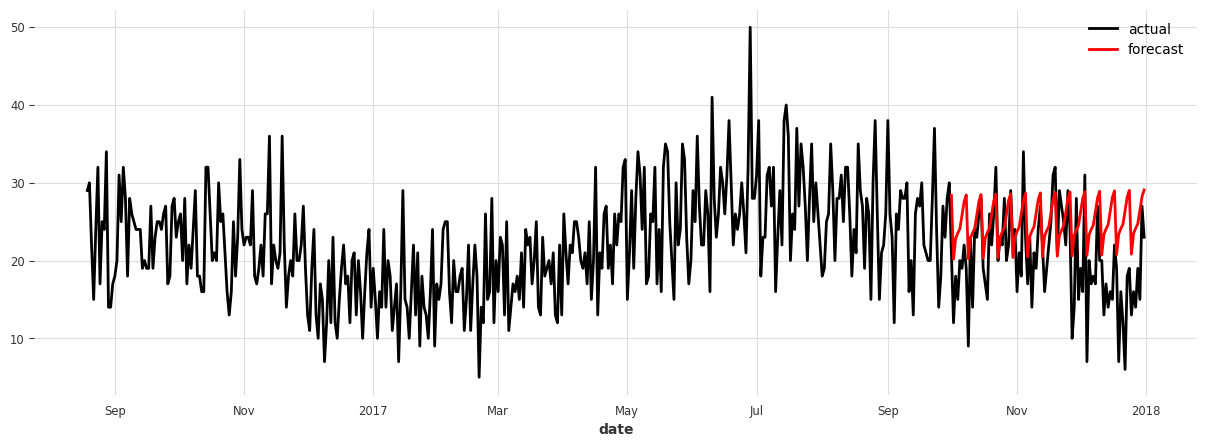

model ExponentialSmoothing() obtains MAPE: 38.98%


In [20]:
# Функція візуалізації результатів
def plot_results(series, forecast):
  plt.figure(figsize = (15, 5))
  series.plot(label = 'actual')
  forecast.plot(label = 'forecast', color = 'red')
  plt.legend()
  plt.show()

# Функція тренування, візуалізація результатів і обчислення помилки прогнозу
def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

# Тренування, візуалізація результатів і обчислення помилки прогнозу моделі ExponentialSmoothing
model_exp_smooth = ExponentialSmoothing()
fit_and_plot(model_exp_smooth, series[-500:], train, val)

**Висновок**:\
Помилка прогнозу, метрика MAPE, складає 38,98%, що більше за значення MAPE у двох попередніх моделях.\
Модель погана.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

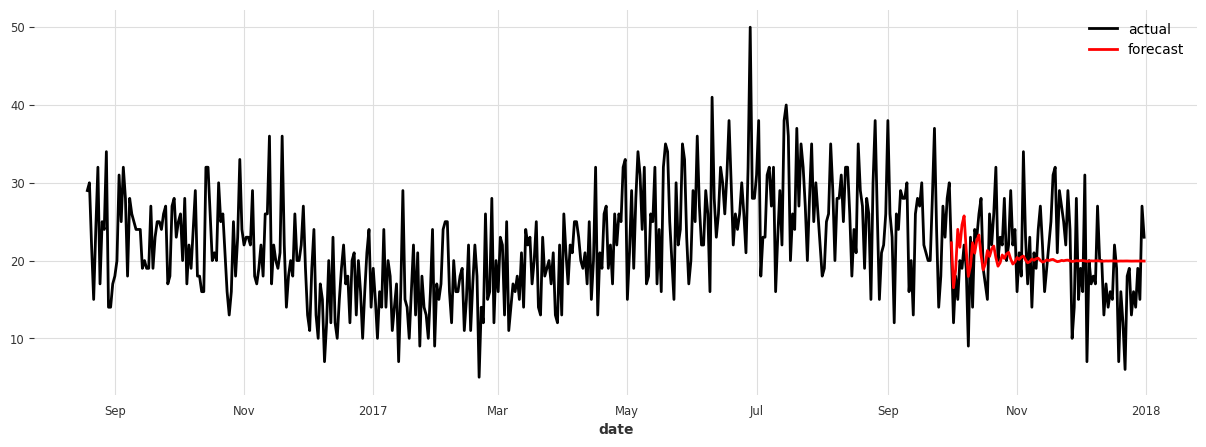

model ARIMA(p=0, d=0, seasonal_order=(1, 0, 0, 7)) obtains MAPE: 28.15%


In [21]:
# Побудова та тренування моделі ARIMA

model_arima = ARIMA(0,0,0, seasonal_order = (1,0,0,7))
fit_and_plot(model_arima, series[-500:], train, val)

**Висновок**:\
Помилка прогнозу, метрика MAPE, складає 28,15%, що краще за попередній результат (38,98%), але все ж залишається високою.\
Модель має погану точність.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

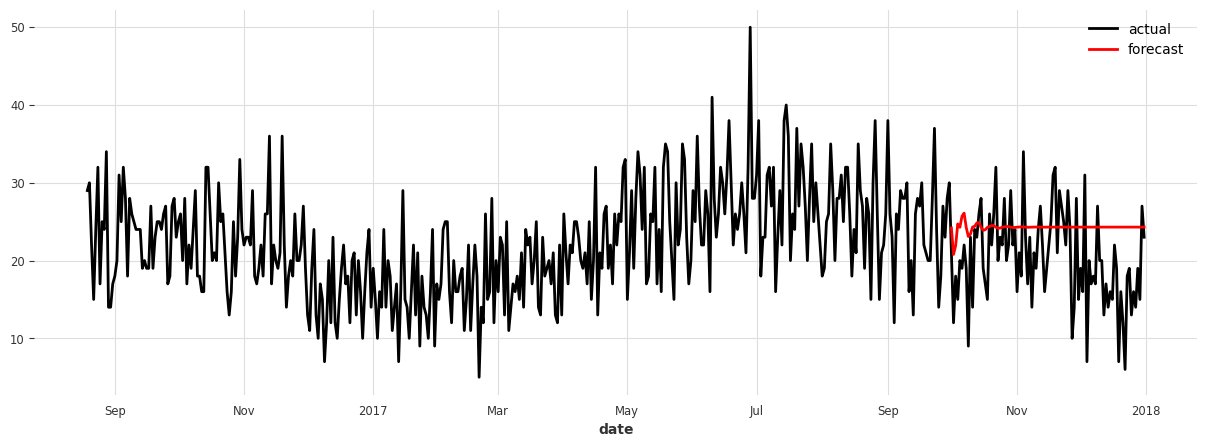

model AutoARIMA(start_p=1, max_p=12, start_q=1) obtains MAPE: 39.53%


In [22]:
# Побудова та тренування моделі AutoArima
model_autoarima = AutoARIMA(start_p=1, max_p=12, start_q=1)
fit_and_plot(model_autoarima, series[-500:], train, val)

In [23]:
model_autoarima.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Fri, 04 Apr 2025   AIC                          10591.078
Time:                        14:46:03   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Висновок**:\
Оптимальними виявились параметри 7,1,1, модель SARIMAX.\
Помилка прогнозу становить 39,53%, що гірше за попередній експеримент (28,15%).

14. Натренуйте модель Prophet та зробіть висновок про її якість.

14:46:16 - cmdstanpy - INFO - Chain [1] start processing
14:46:16 - cmdstanpy - INFO - Chain [1] done processing


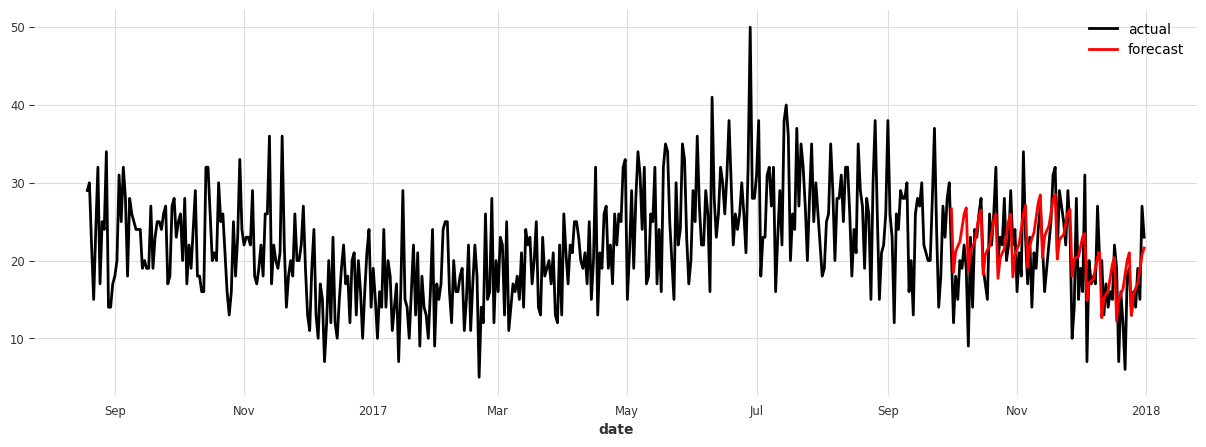

model Prophet() obtains MAPE: 23.80%


In [24]:
model_prophet = Prophet()
fit_and_plot(model_prophet, series[-500:], train, val)

**Висновок**:\
Модель має все ще високу помилку прогнозу (MAPE = 23,80%), але це найкращий результат з усіх попередніх.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

model RNNModel(model=LSTM, hidden_dim=20, input_chunk_length=12, batch_size=16, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, force_reset=True) obtains MAPE: 26.94%


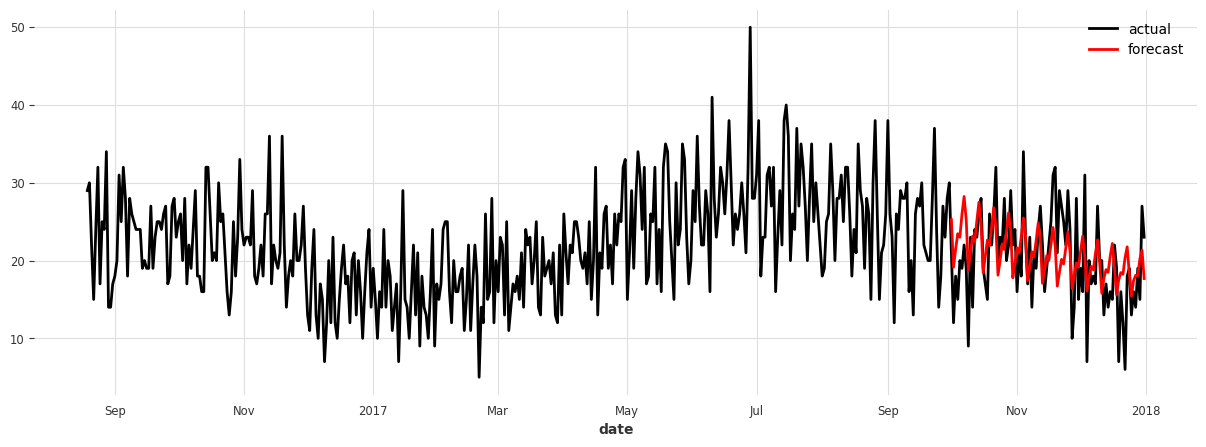

In [25]:
model_rnn = RNNModel(
    model = "LSTM",
    input_chunk_length = 12,
    hidden_dim = 20,
    dropout = 0,
    batch_size = 16,
    n_epochs = 100,
    optimizer_kwargs = {"lr": 1e-3},
    log_tensorboard = True,
    random_state = 42,
    force_reset = True,
)
model_rnn.fit(train_transformed)
pred_rnn = model_rnn.predict(len(val))
forecast_rnn = scaler.inverse_transform(pred_rnn)

eval_forecast(model_rnn, val, forecast_rnn)

plt.figure(figsize = (15, 5))
series[-500:].plot(label = 'actual')
forecast_rnn.plot(label = 'forecast', color='red')
plt.legend()
plt.show()

**Висновок**:\
Модель передбачила і загальний тренд, і коливання, але досить не точно. Тому її не можна вважати вдалою.\
Помилка прогнозу становить 26,94%, що більше ніж показала попередня модель Prophet (23.80%).

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

14:50:52 - cmdstanpy - INFO - Chain [1] start processing
14:50:52 - cmdstanpy - INFO - Chain [1] done processing


historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

14:50:52 - cmdstanpy - INFO - Chain [1] start processing
14:50:52 - cmdstanpy - INFO - Chain [1] done processing
14:50:53 - cmdstanpy - INFO - Chain [1] start processing
14:50:53 - cmdstanpy - INFO - Chain [1] done processing
14:50:53 - cmdstanpy - INFO - Chain [1] start processing
14:50:53 - cmdstanpy - INFO - Chain [1] done processing
14:50:53 - cmdstanpy - INFO - Chain [1] start processing
14:50:53 - cmdstanpy - INFO - Chain [1] done processing
14:50:54 - cmdstanpy - INFO - Chain [1] start processing
14:50:54 - cmdstanpy - INFO - Chain [1] done processing
14:50:54 - cmdstanpy - INFO - Chain [1] start processing
14:50:54 - cmdstanpy - INFO - Chain [1] done processing
14:50:54 - cmdstanpy - INFO - Chain [1] start processing
14:50:54 - cmdstanpy - INFO - Chain [1] done processing
14:50:55 - cmdstanpy - INFO - Chain [1] start processing
14:50:55 - cmdstanpy - INFO - Chain [1] done processing
14:50:55 - cmdstanpy - INFO - Chain [1] start processing
14:50:55 - cmdstanpy - INFO - Chain [1]

MAPE = 24.48%


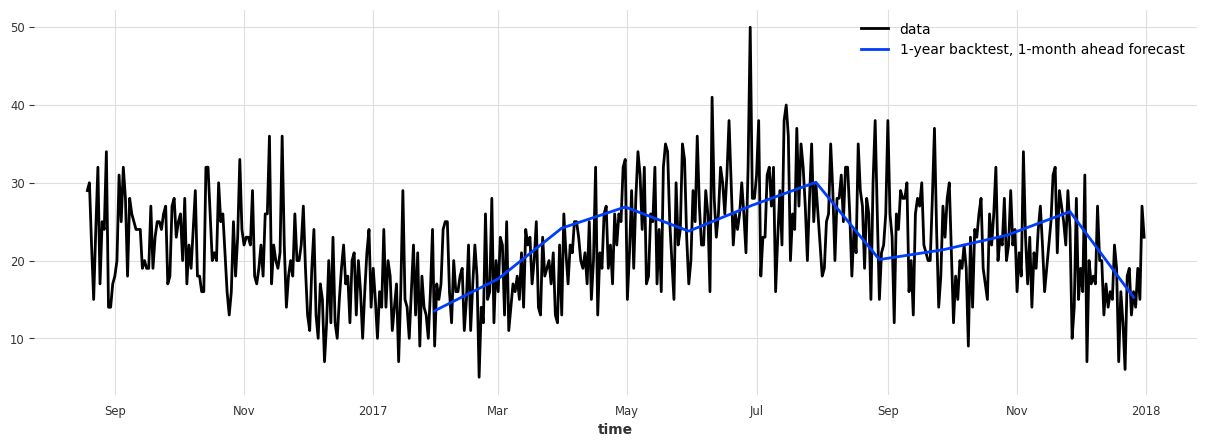

In [26]:
# найкраща модель Prophet

model = Prophet()
model.fit(train)
forecast = model.predict(len(val))

hfc_params = {
    "series": series,
    "start": series.time_index[-365],
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, stride=30, **hfc_params)

plt.figure(figsize = (15, 5))
series[-500:].plot(label = 'data')
historical_fcast.plot(label = '1-year backtest, 1-month ahead forecast')
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

14:51:04 - cmdstanpy - INFO - Chain [1] start processing
14:51:04 - cmdstanpy - INFO - Chain [1] done processing
14:51:05 - cmdstanpy - INFO - Chain [1] start processing
14:51:05 - cmdstanpy - INFO - Chain [1] done processing
14:51:05 - cmdstanpy - INFO - Chain [1] start processing
14:51:05 - cmdstanpy - INFO - Chain [1] done processing
14:51:05 - cmdstanpy - INFO - Chain [1] start processing
14:51:05 - cmdstanpy - INFO - Chain [1] done processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:06 - cmdstanpy - INFO - Chain [1] done processing
14:51:07 - cmdstanpy - INFO - Chain [1] start processing
14:51:07 - cmdstanpy - INFO - Chain [1] done processing
14:51:07 - cmdstanpy - INFO - Chain [1] start processing
14:51:07 - cmdstanpy - INFO - Chain [1]

MAPE = 21.10%


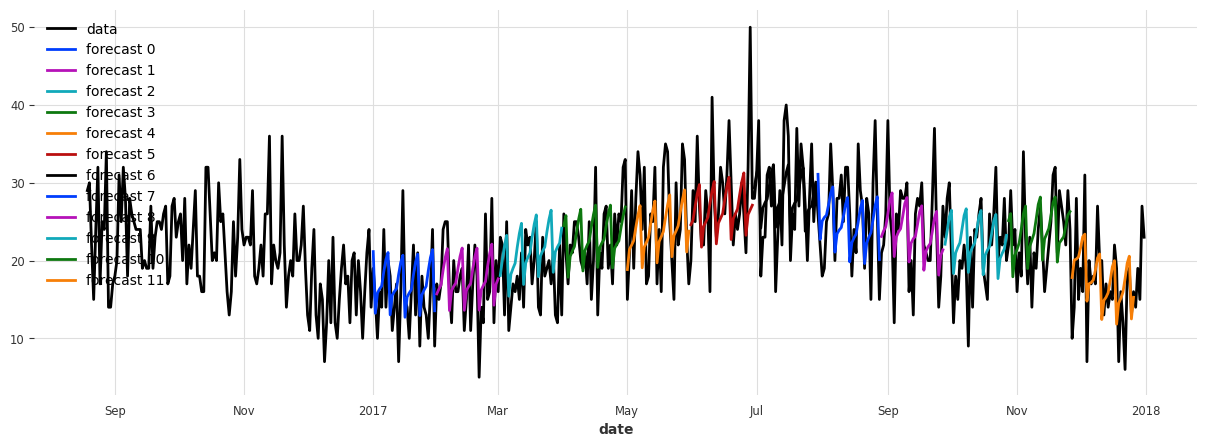

In [27]:
# Всі передбачені значення з кожного історичного прогнозу

historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=30, **hfc_params)

plt.figure(figsize = (15, 5))
series[-500:].plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing
14:51:20 - cmdstanpy - INFO - Chain [1] start processing
14:51:21 - cmdstanpy - INFO - Chain [1] done processing
14:51:21 - cmdstanpy - INFO - Chain [1] start processing
14:51:21 - cmdstanpy - INFO - Chain [1] done processing
14:51:21 - cmdstanpy - INFO - Chain [1] start processing
14:51:21 - cmdstanpy - INFO - Chain [1] done processing
14:51:21 - cmdstanpy - INFO - Chain [1] start processing
14:51:22 - cmdstanpy - INFO - Chain [1] done processing
14:51:22 - cmdstanpy - INFO - Chain [1] start processing
14:51:22 - cmdstanpy - INFO - Chain [1] done processing
14:51:22 - cmdstanpy - INFO - Chain [1] start processing
14:51:22 - cmdstanpy - INFO - Chain [1] done processing
14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:23 - cmdstanpy - INFO - Chain [1]

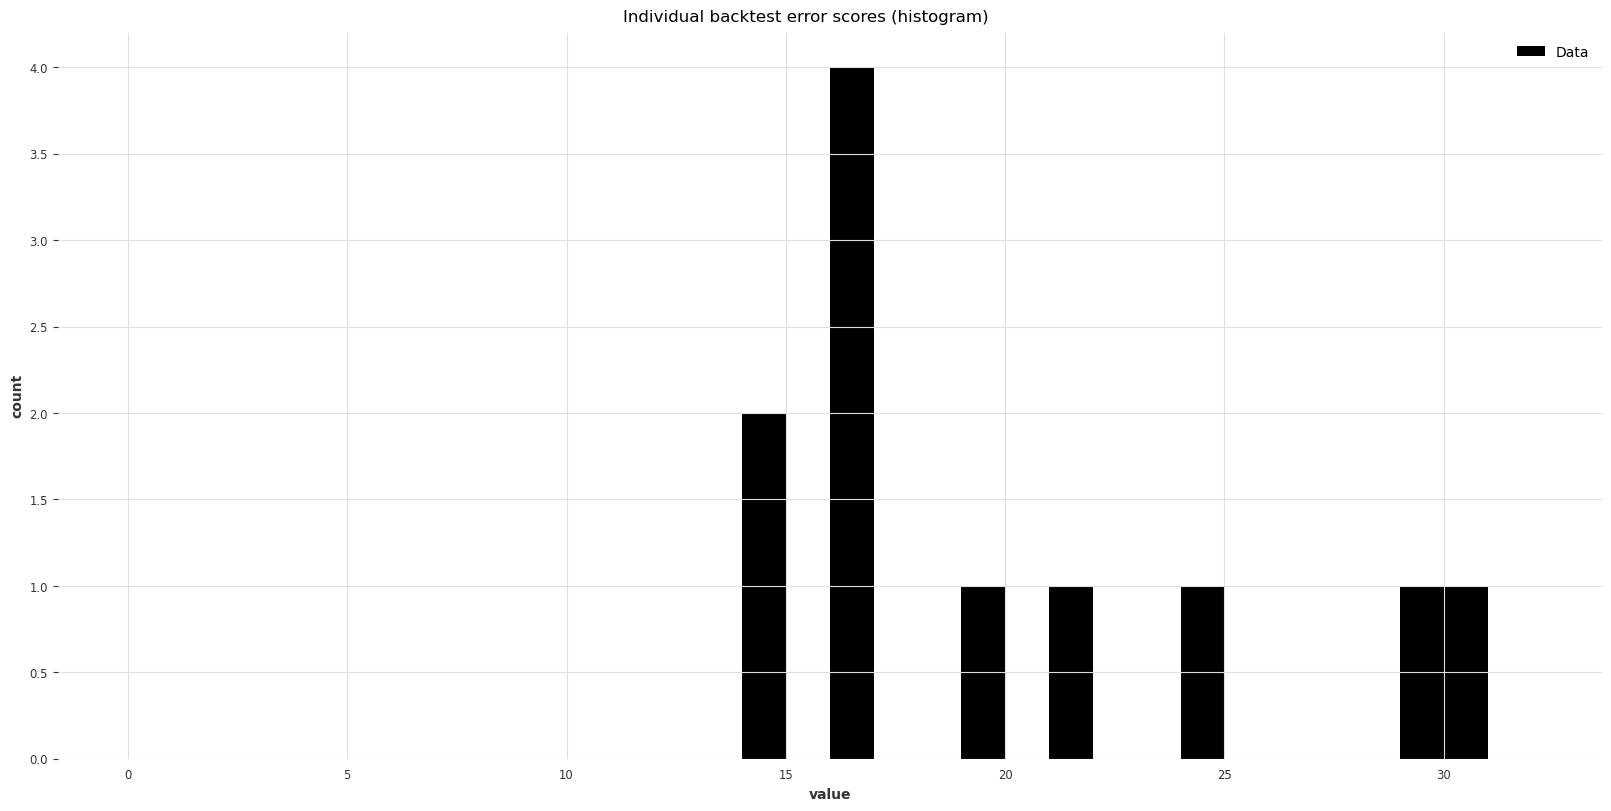

In [28]:
# Сирі помилки і їх розподіл

raw_errors = model.backtest(metric=mape, reduction=None, last_points_only=False, stride=30, **hfc_params)

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [29]:
# Середня помилка за історичними прогнозами

hfc_precomputed = model.historical_forecasts(last_points_only=False, stride=30, **hfc_params)
new_error = model.backtest(historical_forecasts=hfc_precomputed, last_points_only=False, stride=30, **hfc_params)

print(f"Average error (MAPE) over all historical forecasts: {new_error:.2f}")

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] done processing
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] done processing
14:51:39 - cmdstanpy - INFO - Chain [1] start processing
14:51:39 - cmdstanpy - INFO - Chain [1] done processing
14:51:39 - cmdstanpy - INFO - Chain [1] start processing
14:51:39 - cmdstanpy - INFO - Chain [1] done processing
14:51:39 - cmdstanpy - INFO - Chain [1] start processing
14:51:39 - cmdstanpy - INFO - Chain [1] done processing
14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:40 - cmdstanpy - INFO - Chain [1] done processing
14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:40 - cmdstanpy - INFO - Chain [1] done processing
14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing
14:51:41 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1]

Average error (MAPE) over all historical forecasts: 21.10


**Висновок**:\
Для бектесту була обрана модель Prophet, оскільки в попередніх експериментах вона показала найкращий результат.\
Помилки бектесту розподілились в межах 14%-31%.\
Середня помилка склала 21,10%.

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Використовувала б або модель Prophet як просту в налаштуванні і як таку, що підтримує сезонність (плюс як таку, що найкраще себе показала на прогнозуванні продажів одного товару). Або модель XGBoost як гнучку в налаштуванні і таку що має високу точність і здатність обробляти великі обсяги даних (тут важливо витратити час на налаштування оптимальних параметрів).\
Якщо це важливо спрогнозувати продажі кожного з 50 товарів в кожному з 10 магазинів і поденно, то треба було б тренувати 50*10=500 моделей.\
Враховуючи, що це досить затратно по часу і до того ж спрогнозувати поденні продажі складно (моделі показують досить високі помилки прогнозу), можливо, варто агрегувати дані і прогнозувати потижневий чи помісячний сумарний продаж кожного товару для кожного магазину (це зменшить кількість даних ряду).\
Ще, як варіант, класифікувати магазини за схожою динамікою продажу конкретного товару, знайти середнє для кожного класу і прогнозувати його (це зменшить кількість моделей).\
Тому перш за все провела б глибокий аналіз даних.